# Regression

### Import data

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [2]:
print("Shape of train data:", train_data.shape)
print("Shape of test data:", test_data.shape)

Shape of train data: (404, 13)
Shape of test data: (102, 13)


### Preparing the data (Normalization)

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### Construct the model

In [6]:
from keras import models, layers

def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))  
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

### K-fold cross-validation

In [10]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("processing fold {}".format(i))
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]],
        axis=0
    )
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    history = model.fit(
        partial_train_data, 
        partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs,
        batch_size=1,
        verbose=0
    )
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3


In [11]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### Visualize the result

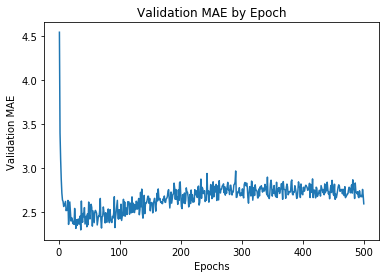

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.title('Validation MAE by Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()
         
# We should remove the first 10 data points to get a better visual

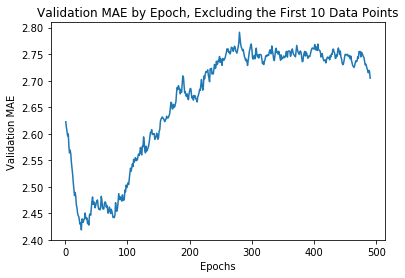

In [23]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.title('Validation MAE by Epoch, Excluding the First 10 Data Points')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()
         
# We see that after epoch 80 the model starts to overfitting

### Training a new model

In [24]:
model = build_model()
model.fit(
    train_data,
    train_targets,
    epochs=80,
    batch_size=16,
    verbose=0
)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

102/102 [==============================] - 0s 2ms/step


2.567888344035429